In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
import kagglehub

In [2]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

100%|██████████| 1.99M/1.99M [00:00<00:00, 76.8MB/s]

Extracting files...


In [3]:
train = pd.read_csv(path + '/twitter_training.csv')
test = pd.read_csv(path + '//twitter_validation.csv')

In [11]:
train.head()

,id,channel,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [9]:
train.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [10]:
train.rename(columns={'2401':'id',  'Borderlands': 'channel', 'Positive':'sentiment', 'im getting on borderlands and i will murder you all ,':'text'}, inplace=True)

In [19]:
test.head()

,id,channel,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [17]:
test.columns

Index(['id', 'channel', 'sentiment', 'text'], dtype='object')

In [16]:
test.rename(columns={'3364':'id',  'Facebook': 'channel', 'Irrelevant':'sentiment', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣':'text'}, inplace=True)

In [18]:
train.sentiment.value_counts()

,count
sentiment,
Negative,22542
Positive,20831
Neutral,18318
Irrelevant,12990


In [20]:
train.isna().sum()

,0
id,0
channel,0
sentiment,0
text,686


In [21]:
test.isna().sum()

,0
id,0
channel,0
sentiment,0
text,0


In [22]:
train.dropna(inplace=True)

In [23]:
train.duplicated().sum()

np.int64(2340)

In [25]:
test.duplicated().sum()

np.int64(0)

In [26]:
train = train.drop_duplicates(keep='first')

In [27]:
X_train, y_train = (train.text, train.sentiment)
X_test, y_test = (test.text, test.sentiment)

In [32]:
import re
def clean(data):
  ## Removing URLs with regex
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  data = url_pattern.sub(r'', data)

  # Remove emails
  data = re.sub('\S*@\S*s?', '', data)

  # Remove new line characters
  data = re.sub('\s+', ' ', data)

  # Remove single quotes
  data = re.sub("\'", "", data)

  return data


In [37]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
def sent_to_words(sentences):
  return [[word for word in word_tokenize(str(sentence).lower()) if word.isalpha()] for sentence in sentences]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [34]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
  return TreebankWordDetokenizer().detokenize(text)

In [35]:
X_train.values.tolist()

['I am coming to the borders and I will kill you all,',
 'im getting on borderlands and i will kill you all,',
 'im coming on borderlands and i will murder you all,',
 'im getting on borderlands 2 and i will murder you me all,',
 'im getting into borderlands and i can murder you all,',
 "So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg",
 "So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Borderlands fan and Maya is one of my favorite characters, I decided to make a wallpaper for my PC.. Here's the original picture compared to the creation I made:) Have fun! pic.twitter.com / mLsI5wf9Jg",
 "So I spent a few hours doing something for fun... If you don't know I'm a HUGE @ Borderlands fan and Maya is one of my fav

In [38]:
temp = []
data_to_list = X_train.values.tolist()
for i in range(len(data_to_list)):
  temp.append(clean(data_to_list[i]))

data_words = list(sent_to_words(temp))
X_train = []
for i in range(len(data_words)):
  X_train.append(detokenize(data_words[i]))

In [39]:
temp = []
data_to_list = X_test.values.tolist()
for i in range(len(data_to_list)):
  temp.append(clean(data_to_list[i]))

data_words = list(sent_to_words(temp))
X_test = []
for i in range(len(data_words)):
  X_test.append(detokenize(data_words[i]))

In [41]:
X_train

['i am coming to the borders and i will kill you all',
 'im getting on borderlands and i will kill you all',
 'im coming on borderlands and i will murder you all',
 'im getting on borderlands and i will murder you me all',
 'im getting into borderlands and i can murder you all',
 'so i spent a few hours making something for fun if you dont know i am a huge fan and maya is one of my favorite characters so i decided to make myself a wallpaper for my pc here is the original image versus the creation i made enjoy',
 'so i spent a couple of hours doing something for fun if you dont know that im a huge borderlands fan and maya is one of my favorite characters i decided to make a wallpaper for my pc heres the original picture compared to the creation i made have fun',
 'so i spent a few hours doing something for fun if you dont know im a huge borderlands fan and maya is one of my favorite characters',
 'so i spent a few hours making something for fun if you dont know i am a huge rhandlerr fan

In [42]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)

sequnces = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequnces, maxlen=max_len)

sequnces = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequnces, maxlen=max_len)

In [46]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [55]:
model = Sequential()
model.add(layers.Embedding(max_words + 1, 50))
model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(50)))
model.add(layers.Dense(4, activation='softmax'))

In [56]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 50)             │         250,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 200, 100)            │          40,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,764 (4.02 MB)

 Trainable params: 351,254 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 702,510 (2.68 MB)

In [66]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
 612/2240 ━━━━━━━━━━━━━━━━━━━━ 11:09 411ms/step - accuracy: 0.5186 - loss: 1.1368

KeyboardInterrupt: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


<Axes: >

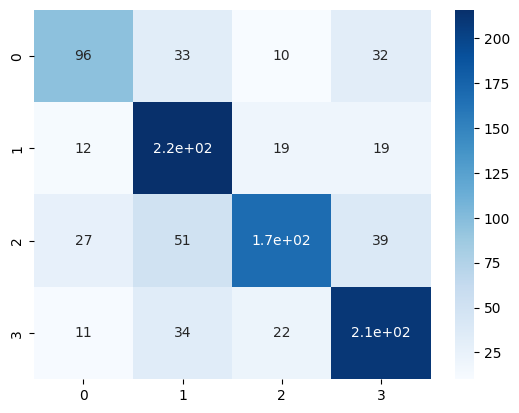

In [67]:
preds = model.predict(X_test)
classes = preds.argmax(axis=1)
sns.heatmap(confusion_matrix(y_test, classes), annot=True, cmap='Blues')

In [68]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       171
           1       0.65      0.81      0.72       266
           2       0.77      0.59      0.67       285
           3       0.70      0.76      0.73       277

    accuracy                           0.69       999
   macro avg       0.69      0.68      0.68       999
weighted avg       0.70      0.69      0.69       999



In [69]:
print("Label mapping: ", dict(zip(encoder.classes_, range(len(encoder.classes_)))))

Label mapping:  {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [81]:
sentiment = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
sequence = tokenizer.texts_to_sequences(['I did not like the acting in this movie. It was really bad'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


'Irrelevant'

In [71]:
model_conv = Sequential()
model_conv.add(layers.Embedding(max_words+1, 50))
model_conv.add(layers.Conv1D(30, 6, activation='relu'))
model_conv.add(layers.MaxPooling1D(5))
model_conv.add(layers.Dropout(0.5))
model_conv.add(layers.Conv1D(30, 6, activation='relu'))
model_conv.add(layers.GlobalMaxPooling1D())
model_conv.add(layers.Dropout(0.5))
model_conv.add(layers.Dense(4, activation='softmax'))

model_conv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_conv.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - acc: 0.3830 - loss: 1.2943 - val_acc: 0.6647 - val_loss: 0.8908
Epoch 2/10
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - acc: 0.6121 - loss: 0.9748 - val_acc: 0.7998 - val_loss: 0.6665
Epoch 3/10
 639/2240 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - acc: 0.6858 - loss: 0.8185

KeyboardInterrupt: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


<Axes: >

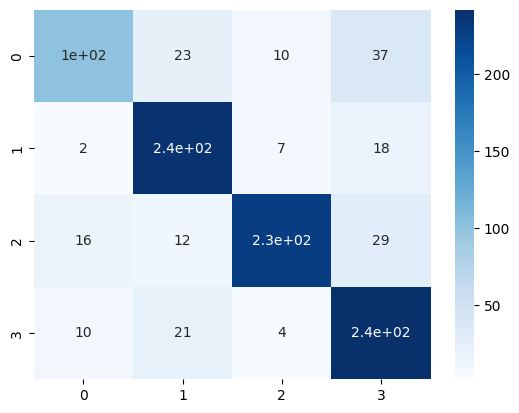

In [72]:
preds = model_conv.predict(X_test)
classes = preds.argmax(axis=1)
sns.heatmap(confusion_matrix(y_test, classes), annot=True, cmap='Blues')

In [73]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       171
           1       0.81      0.90      0.85       266
           2       0.92      0.80      0.85       285
           3       0.74      0.87      0.80       277

    accuracy                           0.81       999
   macro avg       0.81      0.79      0.80       999
weighted avg       0.82      0.81      0.81       999



In [80]:
sentiment = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
sequence = tokenizer.texts_to_sequences(["I did not like the acting in this movie. It was really bad"])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model_conv.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


'Irrelevant'